# Forecast Window 

Let's put our best performing model to the test: we'll have a day's worth of predictions and ask the network to make a forecast on the time series then 

In [130]:
import tensorflow as tf 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np
from scipy import stats

import os

difference = 0.0

# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    minX = np.min(x[np.nonzero(x)])
    maxX = np.max(x[np.nonzero(x)])
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    print(unnorm_fac)
    return x*unnorm_fac + minX
    
# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll

# This function batches up consecutive pieces of data


def batch_consecutive(direc_name):
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    prev_int = int(os.path.splitext(directory_list[0])[0])
    total_batches = []
    consecutive_batch = []
    for jj, name in enumerate(directory_list):
        name_int = int(os.path.splitext(name)[0])
        if (name_int-prev_int==1) or (name_int-prev_int==0):
            consecutive_batch.append(name)
        elif(name_int-prev_int>1):
            total_batches.append(consecutive_batch)
            consecutive_batch = []
        prev_int = name_int
    total_batches.append(consecutive_batch)
    return total_batches

    
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8



In [258]:
# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data_select(x, minX, maxX):  
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    
    normed[normed>1] =  0
    
    return normed, minX, maxX


def load_data(total_batches, time_steps, input_list, window_size, num_of_examples, minOut_X, maxOut_X, full_time_series=False, pad_output_zeros = True,  forecast_len=1, time_res=1, start_index=0):

    total_input = []
    total_output = []
    
    print(f'Parameter List: {input_list}')
    
    num_of_zeros = 0
    num_features = len(input_list)
    
    
    for jj, name in enumerate(total_batches, start=start_index):
        
        df = pd.read_csv(f'{direc_name}/{name}')
        print(name)
        #print(name)
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation'})
        #print(df.columns)
        #input()
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
            #print(jj)
            num_of_zeros += 1
            print(f'number of zeros: {num_of_zeros}')
            print('error data detected. Skipping to next value')
            continue
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((output_len, 1))
        
        ###### INPUT DATA #######
        
        for ii, colName in enumerate(input_list):
            if(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName][time_steps:].to_numpy())
            else:
                dataset_weather[:,ii] = df[colName][time_steps:].to_numpy()
                
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        
        # First, let's consider every example up to forecast length 
        nn_output  = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        
        # Next, only consider every time_res example in the final output
        dataset_output[:,0] = nn_output[np.mod(np.arange(len(nn_output)),time_res) == 0]
        
        # Let's consider wildly varying output data. Compute the difference between maximum and minimum. 
        max_CN2 = np.max(np.abs(dataset_output[:,0]))
        min_CN2 = np.min(np.abs(dataset_output[:,0]))
        
        diff = np.abs(max_CN2 - min_CN2)
        
        if (diff >= -1):
            total_input.append(dataset_weather)
            total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
            
        if (jj-start_index>num_of_examples):
            print("Finished loading data!")
            break;
                
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply rolling average onto the input data
    total_input = rollify_training(total_input, window_size)
    
    # Apply normalization to each input entry (except for CN2, this needs to be handled specially)
    for ii in np.delete(np.arange(len(input_list)), 2):
        #print(ii)
       # total_input[:,:,ii], minOut,maxOut = norm_data(total_input[:,:,ii])
        # print(minOut)
        # print(maxOut)
        
        total_input[:,:,ii],_,_ = norm_data_select(total_input[:,:,ii], minOut_X[ii], maxOut_X[ii])

    # If we are working with time series prediction, apply rolling on output time series
    
    if (full_time_series):
        total_output = rollify_training(total_output, window_size)
    
    # Finally, if we're working with a time series, let's pad out the output array with 0s
    
    window_time_steps_input = total_input.shape[1]
    window_time_steps_output = total_output.shape[1]
    dataset_len = int(total_input.shape[0])

    total_output_padded = np.zeros((total_input.shape[0], window_time_steps_input, 1))

    total_output_padded[:,:window_time_steps_output, 0] = total_output[:,:,0]

    # At this point, normalize the CN2 for BOTH input and output. This is important!
    
    ziggy = np.concatenate((total_input[:,:,2], total_output_padded[:,:,0]))
    ziggy, _,_ = norm_data_select(ziggy, minOut_X[2], maxOut_X[2])
    

    total_input[0:dataset_len,:,2] = ziggy[0:dataset_len, :]
    total_output_padded[0:dataset_len,:,0] = ziggy[dataset_len::,:]
    
    if(full_time_series):
        if (pad_output_zeros==False):
            total_output[:,:,0] = total_output_padded[:,0:output_len,0]
            return total_input, total_output, minOut, maxOut
        return total_input, total_output_padded, minOut, maxOut 
    else:
        return total_input, total_output_padded[:,0], minOut, maxOut
    
    

# Some tests

To begin, load the champion model

In [213]:
fifthteenMin_timeRes =  'trainSeries_15MinInput_6Hour_9487'

#fifthteenMin_timeRes = 'trainSeries_oneHourWindow_4Hour_5364'

loaded_model = tf.keras.models.load_model(f'models/{fifthteenMin_timeRes}', custom_objects={'mse_mod':mse_mod})

Load the data

In [275]:

input_features = ['relative_humidity', 'solar_radiation', 'CN2', 'temperature']

# For consistency, normalize the data wrt training. 

minOut_X = [25.47199, -0.3995518, -16.46344155742847, -18.04353]
maxOut_X = [99.52488, 71.5599, -13.787812395596042, 32.07004]

time_len = 720
time_res = 15
forecast_len = 360
output_len = int(forecast_len/time_res)
start_index =  0
batch_index = -4

direc_name = f"Batched Data/OneMinResolution_4HourSkip" # yaml worthy
total_batches = batch_consecutive(direc_name)

X, y, minOut, maxOut = load_data(total_batches[batch_index], time_len, input_features, 1, 2000, minOut_X, maxOut_X, full_time_series=True, pad_output_zeros=False, forecast_len=forecast_len, time_res=time_res, start_index=start_index)
# minOut = -16.46344155742847
# maxOut = -13.787812395596042
#print(len(y))


Parameter List: ['relative_humidity', 'solar_radiation', 'CN2', 'temperature']
00001347.csv
Data loaded:0
00001348.csv
00001349.csv
00001350.csv
00001351.csv
00001352.csv
00001353.csv


In [272]:
np.min(X)

0.00410305515973928

Compute predictions from each loaded time series to create a predicted 12 hour time series 

In [273]:
def rms(y_true, y_pred):
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

forecasts = []

total_forecasts = np.array([])
y_total = np.array([])

for ii in range(len(y)):
    munky = tf.expand_dims(X[ii,:,:], axis=0)
    preds = loaded_model.predict(munky, verbose=False)
    preds = np.array(preds[0]).flatten()
    
    total_forecasts = np.concatenate([total_forecasts, preds])
    y_total = np.concatenate((y_total,y[ii,:,0]))
    
total_hours = len(total_forecasts)
#foxy = rms(total_forecasts, y_total)
#print(np.mean(foxy))

total_forecasts = 10**(unnorm_data(total_forecasts, minOut, maxOut))

# total_forecast = np.concatenate((forecasts[0,:], forecasts[1,:], forecasts[2,:], forecasts[3,:], forecasts[4,:], forecasts[5,:]))
# y_total = np.concatenate((y[0,:,0], y[1,:,0], y[2,:,0], y[3,:,0], y[4,:,0], y[5,:,0]))

#foxy = rms(total_forecast, y_total)

2.089610774266557


In [268]:
len(total_forecasts)

216

Plot the forecast

2.089610774266557


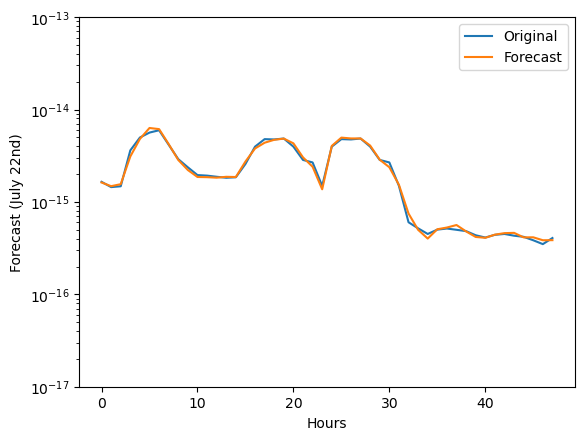

In [274]:
hours = np.arange(total_hours)
y_CN2 = 10**(unnorm_data(y_total, minOut, maxOut))

plt.plot(hours, y_CN2, label='Original')
plt.yscale('log')
plt.ylim(10**-17, 10**-13)
plt.xlabel('Hours')
plt.ylabel('Forecast (July 22nd)')
plt.plot(hours, total_forecasts, label='Forecast')
plt.legend()


In [16]:
144*4

576